# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lets_plot import *

In [2]:
#from datalore.display import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [4]:
def to_scalar(x, i):
    """Returns i-th element from an array x if x is array, else returns x
Args:
    x - input array
    i - index to return
Returns:
    x[i] if x is an array and x else
"""
    if isinstance(x, (np.ndarray, list)):
        return x[i]
    return x

In [5]:
def gradient_checker(J, grad_J, theta, eps=1e-4, rtol=1e-5):
    """Gradient checker for scalar and vector functions
Args:
    J - function of theta
    grad_J - gradient of function J
    theta - the point for which to compute the numerical gradient
    eps - step value in numerical gradient
    rtol - relative tolerance threshold value
Returns:
    error message if the relative tolerance is greater for some axis
    or "Gradient check passed" else
"""
    it = np.nditer(theta, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:
        ix = it.multi_index

        theta_ = np.array(theta, copy=True)
        theta_[ix] += eps
        J1 = J(theta_)

        theta_ = np.array(theta, copy=True)
        theta_[ix] -= eps
        J2 = J(theta_)

        J1 = to_scalar(J1, ix)
        J2 = to_scalar(J2, ix)

        num_grad = (J1 - J2)/(2*eps)

        rel_tol = np.abs(num_grad - grad_J(theta))[ix]/(1. + np.minimum(np.abs(num_grad), np.abs(grad_J(theta)[ix])))

        if np.all(rel_tol > rtol):
            print(f'Incorrect gradient for the axis {str(ix)}')
            return
        it.iternext()
    print(f'Gradient check passed')

In [6]:
def J_theta_global(model, loss_function, theta, idx, x, y):
    previous = model.parameters()[idx].copy()
    np.copyto(dst=model.parameters()[idx], src=theta)
    outputs = model(x)
    loss = loss_function(outputs, y)
    np.copyto(dst=model.parameters()[idx], src=previous)
    return loss

In [7]:
def dJ_theta_global(model, loss_function, theta, idx, x):
    grad = model.backward(loss_function)[idx] / x.shape[0]
    return grad.reshape(theta.shape)

In [8]:
def sigmoid(x,slope=1.0):
    return 1.0/(1.0+np.exp(-slope*x))

In [9]:
def sigmoid_prime(x,slope=1.0):
    return slope*sigmoid(x,slope=slope)*(1.0-sigmoid(x,slope=slope))

In [10]:
z = np.random.normal(size=5)
gradient_checker(sigmoid, sigmoid_prime, z, eps=1e-4, rtol=1e-5)

Gradient check passed


In [11]:
def plot_digit(digit, size=8, caption=None):
    digit = digit.reshape(size, size)
    digit = (digit - np.min(digit))/(np.max(digit) - np.min(digit))
    p = ggplot() + geom_image(image_data=digit) + labs(x='', y='') \
        + theme(axis_line='blank', axis_title='blank', axis_ticks='blank', axis_text='blank')
    if caption:
        p += ggtitle(caption)
    return p;

In [12]:
def gg_confusion_matrix(y, y_hat):
    conf_mat = confusion_matrix(y, y_hat)[::-1]
    confusion_dat = pd.DataFrame(conf_mat)
    observed = confusion_dat.columns.values
    actual = confusion_dat.index.values
    xx, yy = np.meshgrid(actual, observed)
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    zz = conf_mat.reshape(-1)
    dat = {'predicted':xx, 'actual':yy[::-1], 'z':zz}
    p = ggplot(dat, aes('predicted', 'actual', fill='z')) \
        + geom_raster() \
        + geom_text(aes(label='z'), color='white')\
        + theme(legend_position='none', axis_ticks='blank', axis_line='blank')\
        + ggsize(500, 500) + scale_x_discrete() + scale_y_discrete()\
        + ggtitle('Confusion matrix')
    return p

In [13]:
def f1_score_micro(conf_matrix):
    num_tags = conf_matrix.shape[0]
    score = 0.
    pr, p, r = 0., 0., 0.
    for tag in range(num_tags):
        pr += conf_matrix[tag, tag]
        p += sum(conf_matrix[tag, :])
        r += sum(conf_matrix[:, tag])
    try:
        score = 2 * pr / (p + r)
    except ZeroDivisionError:
        pass
    return score

In [14]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [15]:
import matplotlib.ticker as ticker

In [16]:
import itertools

In [17]:
def plot_confusion_matrix(conf_matrix, labels, title='Confusion matrix', cmap: str='Oranges'):
    norm_cm = conf_matrix / conf_matrix.sum(axis=0)
    norm_cm[norm_cm != norm_cm] = .0  # eliminate NaN
    
    fig: Figure = Figure(figsize=(7, 7))
    ax: Axes = fig.add_subplot(1, 1, 1)
    ax.set_title(label=title)

    ax.matshow(norm_cm, cmap=cmap)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    ax.set_xticklabels([''] + labels, rotation=90)
    ax.set_yticklabels([''] + labels)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.grid(False)
    plt.tight_layout()

    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        ax.text(j, i, format(int(conf_matrix[i, j]), 'd') if conf_matrix[i, j] != 0 else '.',
                horizontalalignment='center', verticalalignment='center', fontsize=6, color='black')
    fig.set_tight_layout('true')
    return fig

# FFN

# Problems 1 and 2 starter code
You can see below the starter code for the group of tasks related to feedforward networks. 

In [18]:
from sklearn.datasets import load_digits

In [19]:
from typing import List, Optional, Union
import json
import time

In [20]:
digits_bunch = load_digits()
digits_df = pd.DataFrame(digits_bunch.data)
digits_df['target'] = pd.Series(pd.Categorical.from_codes(digits_bunch.target, categories=digits_bunch.target_names))

In [21]:
X, y = digits_df.drop('target', axis=1), digits_df['target']
print('X shape: {}, y shape: {}'.format(X.shape, y.shape))

X shape: (1797, 64), y shape: (1797,)


In [22]:
X, y = X.values, y.values
y = y.astype(int)
X = X / 16

In [23]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)
print('X_train shape: {}, X_val shape: {}, X_test shape: {}'.format(X_train.shape, X_val.shape, X_test.shape))

X_train shape: (1149, 64), X_val shape: (288, 64), X_test shape: (360, 64)


In [24]:
random_ind = np.random.randint(low=0, high=X.shape[0], size=100)
digit_examples = X[random_ind]

In [25]:
bunch = GGBunch()
x0, y0 = 0, 0
row = 0
col = 0
width = 50
height = width
step = width + 0
n_cols = 10
for digit in digit_examples:
    if col == n_cols:
        col = 0
        row += 1
    plot = plot_digit(digit)
    bunch.add_plot(plot, x0 + col*step, y0 + row*step, width, height)
    col += 1
bunch.show()

In [26]:
class Function:
    def __call__(self) -> "Tensor":
        pass
    
    def backward(self, *args, **kwargs):
        pass

In [27]:
class Tensor:
    def __init__(self, data: np.ndarray, func: Optional[Function]=None, name: str=None):
        self.data: np.ndarray = data
        self.grad: np.ndarray = np.zeros(data.shape)
        self.func = func
        self.__name__ = name
    
    def backward(self, grad: Optional[np.ndarray] = None):
        if grad is not None:
            assert grad.shape == self.grad.shape
            self.grad += grad
            if self.func:
                self.func.backward(grad)
        else:
            if self.func:
                self.func.backward()

    def zero_grad(self):
        self.grad[:] = .0
    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def size(self):
        return self.data.size
    
    def astype(self, dtype: Union[str, np.dtype]):
        return self.data.astype(dtype)
    
    def __str__(self) -> str:
        return str(self.data)

In [28]:
class Module:
    def __init__(self):
        self.parameters: List[Tensor] = []
        self.__name__ = self.__class__.__name__
        self.state_dict = {}
        self.training = True
    
    @staticmethod
    def get_module_state_dict(module: "Module"):
        keys = [param.__name__ for param in module.__dict__['parameters']]
        values = [param.data.tolist() for param in module.__dict__['parameters']]
        return dict(zip(keys, values))
     
    def update_state_dict(self):
        module_state_dicts = []
        module_names = []
        for key in self.__dict__:
            value = self.__dict__[key]
            base_class_name = value.__class__.__bases__[0].__name__
            class_name = value.__class__.__name__
            if base_class_name == 'Module':
                class_has_parameters = hasattr(value, "parameters")
                if class_has_parameters:
                    parameters_not_empty = len(value.parameters) > 0
                    if parameters_not_empty:
                        module_names.append(key)
                        module_state_dict = self.get_module_state_dict(value)
                        module_state_dicts.append(module_state_dict)
        self.state_dict = dict(zip(module_names, module_state_dicts))

    def register_parameter(self, param: Tensor):
        self.parameters.append(param)

    def register_parameters(self, param_list_or_module: Union[List[Tensor], "Module", List["Module"]]):
        if isinstance(param_list_or_module, List):
            for element in param_list_or_module:
                if isinstance(element, Tensor):
                    self.register_parameter(element)
                elif isinstance(element, Module):
                    for param in element.parameters:
                        self.register_parameter(param)
                else:
                    raise TypeError("Parameter should be of type Tensor")
        elif isinstance(param_list_or_module, Module):
            for param in param_list_or_module.parameters:
                self.register_parameter(param)
        self.update_state_dict()
    
    def zero_grad(self):
        for param in self.parameters:
            param.zero_grad()
    
    def forward(self, *args, **kwargs):
        raise NotImplementedError
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def size(self):
        s = 0
        for param in self.parameters:
            s += param.data.size
        return s
    
    def update_parameters_from_state_dict(self):
        for key in self.__dict__:
            if key in self.state_dict:
                for param in self.__dict__[key].parameters:
                    param.data = np.asarray(self.state_dict[key][param.__name__])

    def save(self, filename: str = None):
        if filename is None:
            filename = time.strftime("%Y%m%d-%H%M%S") + '.json'
        self.update_state_dict()
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.state_dict, f, ensure_ascii=False, indent=4)
    
    def load(self, filename: str):
        with open(filename, 'r') as f:
            json_str = f.read()
            self.state_dict = json.loads(json_str)
        self.update_parameters_from_state_dict()
    
    def train(self):
        for key in self.__dict__:
            module = self.__dict__[key]
            base_class_name = module.__class__.__bases__[0].__name__
            if base_class_name == 'Module':
                module.training = True
    
    def eval(self):
        for key in self.__dict__:
            module = self.__dict__[key]
            base_class_name = module.__class__.__bases__[0].__name__
            if base_class_name == 'Module':
                module.training = False

In [29]:
def Wandb(in_dim, out_dim):
    W = np.random.normal(loc=0, scale=0.1, size=(in_dim, out_dim))
    b = np.random.normal(loc=0, scale=0.1, size=(1, out_dim))
    return Tensor(W, name='weights'), Tensor(b, name='bias')

In [30]:
class Linear(Function):
    def __init__(self, x: Tensor, W: Tensor, b: Tensor = None):
        self.x = x
        self.W = W
        self.b = b

    def __call__(self):
        outputs = np.dot(self.x.data, self.W.data) + self.b.data
        return Tensor(outputs, func=self)

    def backward(self, grad: np.ndarray):
        dW = np.dot(self.x.data.T, grad)
        db = grad.sum(axis=0)
        grad = np.dot(grad, self.W.data.T)
        self.W.backward(dW.reshape(self.W.shape))
        self.b.backward(db.reshape(self.b.shape))
        self.x.backward(grad.reshape(self.x.shape))

In [31]:
class LinearLayer(Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.W, self.b = Wandb(in_dim, out_dim)
        self.register_parameters([self.W, self.b])
        self.x = None

    def forward(self, x: Tensor):
        return Linear(x, self.W, self.b)()

In [32]:
def sigmoid(x):
    s = 1.0 / (1.0 + np.exp(-x))
    return s

In [33]:
class Sigmoid(Function):
    def __init__(self, x: Tensor):
        self.x = x

    def __call__(self):
        self.a = sigmoid(self.x.data)
        return Tensor(self.a, self)

    def backward(self, grad: np.ndarray):
        grad = self.a * (1. - self.a) * grad.reshape(self.a.shape)
        self.x.backward(grad)

In [34]:
class SigmoidFunction(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor):
        return Sigmoid(x)()

In [35]:
def softmax(x: Tensor):
    a = np.amax(x.data, axis=1)[:, np.newaxis]
    ex = np.exp(x.data - a)
    ex_sum = np.sum(ex, axis=1)[:, np.newaxis]
    out = ex / ex_sum
    return Tensor(out, x.func)

In [36]:
def one_hot_encoder(labels: Tensor, n_classes=10):
    encoded = np.zeros((labels.size, n_classes))
    encoded[np.arange(labels.size), labels.astype(int)] = 1
    return Tensor(encoded)

In [37]:
class NLL(Function):
    def __init__(self, y_hat: Tensor, y: Tensor, eps: float = 1e-15):
        self.y_hat = softmax(y_hat)
        self.y = one_hot_encoder(y)
        self.eps = eps

    def __call__(self):
        logs = np.log(self.y_hat.data + self.eps)
        loss = np.multiply(-self.y.data, logs).sum(axis=1).sum()
        return Tensor(loss, self)
    
    def backward(self):
        grad = self.y_hat.data - self.y.data
        self.y_hat.backward(grad)

In [38]:
class CrossEntropyLoss(Module):
    def __init__(self, eps=1e-15):
        super().__init__()
        self.eps = eps

    def forward(self, output, target):
        return NLL(output, target, self.eps)()

In [39]:
class Optimizer:
    def __init__(self, params: List[Tensor], lr: float = 0.001):
        self.params = params
        self.lr = lr

    def step(self, *args, **kwargs):
        raise NotImplemented
    
    def zero_grad(self):
        for param in self.params:
            param.zero_grad()

In [40]:
class SGD(Optimizer):
    def __init__(self, params: List[Tensor], lr: float = 0.001):
        super().__init__(params, lr)

    def step(self):
        for param in self.params:
            param.data -= self.lr * param.grad

In [41]:
class Scheduler:
    def __init__(self, optimizer: Optimizer, last_epoch: int = -1):
        self.optimizer = optimizer
        self.base_lr = optimizer.lr
        self.last_epoch = last_epoch
    
    def step(self):
        raise NotImplementedError

In [42]:
class ConstantLR(Scheduler):
    def __init__(self, optimizer: Optimizer):
        super().__init__(optimizer)
        self.lr = optimizer.lr
    
    def step(self):
        self.last_epoch += 1

In [43]:
class CosineAnnealingLR(Scheduler):
    def __init__(self, optimizer: Optimizer, T_max: int, eta_min: float = 0, anneal_epochs: int = None, last_epoch: int = -1):
        super().__init__(optimizer)
        self.T_max = T_max
        self.eta_min = eta_min
        self.lr = optimizer.lr
        self.last_epoch = last_epoch
        self.start_epoch = last_epoch
        self.anneal_epochs = anneal_epochs
    
    @staticmethod
    def _cosine_anneal(t):
        return (1 + np.cos(np.pi * t)) / 2

    def get_lr(self):
        if self.anneal_epochs is not None:
            passed_epochs = self.last_epoch - self.start_epoch
            if passed_epochs > self.anneal_epochs:
                return self.lr
        t = self.last_epoch / self.T_max
        return self.eta_min + (self.base_lr - self.eta_min) * self._cosine_anneal(t)
    
    def step(self):
        self.lr = self.get_lr()
        self.optimizer.lr = self.lr
        self.last_epoch += 1

In [44]:
def xavier_(weights):
    for weight in weights:
        in_dim, out_dim = weight.shape[-2:]
        np.copyto(dst=weight.data, src=np.random.randn(*weight.shape) * np.sqrt(2. / (in_dim + out_dim)))

In [45]:
class Feedforward(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = LinearLayer(64, 32)
        self.fc2 = LinearLayer(32, 10)
        self.sigmoid = SigmoidFunction()

        xavier_(self.fc1.parameters)
        xavier_(self.fc2.parameters)
        self.register_parameters([self.fc1, self.fc2])

    def forward(self, x: Tensor):
        z1 = self.fc1(x)
        a1 = self.sigmoid(z1)
        z2 = self.fc2(a1)
        return z2

In [46]:
class DataLoader:
    def __init__(self, data, target, batch_size=20):
        self.data = data
        self.target = target
        self.batch_size = batch_size

    def next(self):
        m, _ = self.data.shape
        rand_index = np.random.choice(m, size=m, replace=False)
        X, y = self.data[rand_index], self.target[rand_index]
        pos = 0
        while pos < m:
            X_batch, y_batch = X[pos:pos+self.batch_size], y[pos:pos+self.batch_size]
            yield Tensor(X_batch), Tensor(y_batch)
            pos += self.batch_size

    def __call__(self):
        return self.next()

In [47]:
def eval_accuracy(model, val, y_val):
    output = model(Tensor(val))
    y_hat = np.argmax(output.data, axis=1)
    return accuracy_score(y_val, y_hat)

In [48]:
num_epochs = 50
dataloader = DataLoader(X_train, y_train)
model = Feedforward()
loss_function = CrossEntropyLoss()
optimizer = SGD(model.parameters, lr=0.1)
scheduler = ConstantLR(optimizer)

In [49]:
model.size()

2410

# Training

In [50]:
losses = []
accuracies = []
lrs = []
for epoch in range(num_epochs):
    loss_sum = 0
    for data in dataloader():
        optimizer.zero_grad()
        inputs, targets = data
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_sum += loss.data
    acc = eval_accuracy(model, X_val, y_val)
    print(f'\r epoch: [{epoch+1}/{num_epochs}], loss: {loss_sum}, acc: {acc}', end='')
    losses.append(loss_sum)
    accuracies.append(acc)
    lrs.append(scheduler.lr)
    scheduler.step()

 epoch: [50/50], loss: 5.997034926596314, acc: 0.9722222222222222

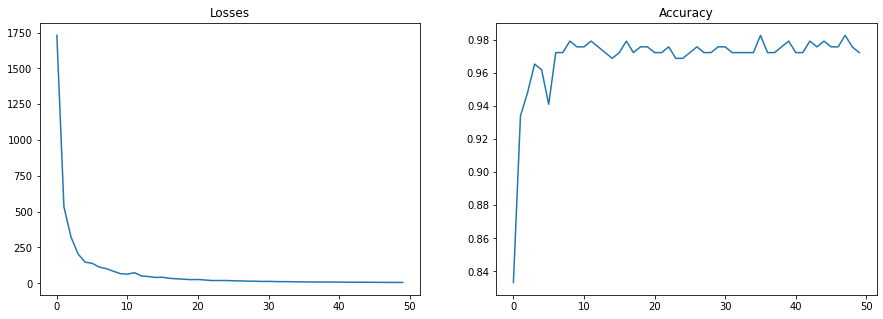

In [51]:
epochs = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(epochs, losses)
ax[0].set_title('Losses')
ax[1].plot(epochs, accuracies)
ax[1].set_title('Accuracy');

# Train set confusion matrix

In [52]:
model.eval()
y_hat = model(Tensor(X_train))
y_pred = np.argmax(y_hat.data, axis=1)

In [53]:
gg_confusion_matrix(y_train, y_pred) + ggsize(500, 500)

In [54]:
cm = confusion_matrix(y_train, y_pred)
score = f1_score_micro(cm)
print(f'F1 score micro: {score}')

F1 score micro: 1.0


# Test set confusion matrix

In [55]:
model.eval()
y_hat = model(Tensor(X_test))
y_pred = np.argmax(y_hat.data, axis=1)

In [56]:
gg_confusion_matrix(y_test, y_pred) + ggsize(500, 500)

In [57]:
cm = confusion_matrix(y_test, y_pred)
score = f1_score_micro(cm)
print(f'F1 score micro: {score}')

F1 score micro: 0.9694444444444444


# Check gradients

A very detailed list of tips and tricks for gradient checks and sanity checks can be found here: [http://cs231n.github.io/neural-networks-3/#ensemble](http://cs231n.github.io/neural-networks-3/#ensemble)

In [58]:
def gradient_checker(J, grad_J, theta, eps=1e-5, rtol=1e-5):
    """Gradient checker for scalar and vector functions
Args:
    J - function of theta
    grad_J - gradient of function J
    theta - the point for which to compute the numerical gradient
    eps - step value in numerical gradient
    rtol - relative tolerance threshold value
Returns:
    error message if the relative tolerance is greater for some axis
    or "Gradient check passed" else
"""
    it = np.nditer(theta, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:
        ix = it.multi_index
        theta_ = np.array(theta, copy=True)
        theta_[ix] += eps
        J1 = J(theta_)
        theta_ = np.array(theta, copy=True)
        theta_[ix] -= eps
        J2 = J(theta_)

        J1 = to_scalar(J1, ix)
        J2 = to_scalar(J2, ix)

        num_grad = (J1 - J2)/(2*eps)

        rel_tol = np.abs(num_grad - grad_J)[ix]/(1. + np.minimum(np.abs(num_grad), np.abs(grad_J[ix])))

        if rel_tol > rtol:
            print(f'num_grad: {num_grad} grad: {grad_J[ix]} factor: {grad_J[ix] / num_grad}')
            print(f'Incorrect gradient for the axis {str(ix)}')
            return
        it.iternext()
    print(f'Gradient check passed')

In [59]:
def J_theta_global(model, loss_function, theta, idx, x, y):
    original = model.parameters[idx].data.copy()
    np.copyto(dst=model.parameters[idx].data, src=theta)
    outputs = model(x)
    loss_value = loss_function(outputs, y).data
    np.copyto(dst=model.parameters[idx].data, src=original)
    model.zero_grad()
    return loss_value

In [60]:
def dJ_theta_global(model, loss_function, x, y):
    outputs = model(x)
    loss = loss_function(outputs, y)
    loss.backward()
    grads = []
    for parameter in model.parameters:
        grads.append(parameter.grad.copy())
    model.zero_grad()
    return grads

In [61]:
loss_function = CrossEntropyLoss()
model_ = Feedforward()
dJ_theta_tensors = dJ_theta_global(model_, loss_function, Tensor(X_val), Tensor(y_val))
global_start = time.time()
for i, parameter in enumerate(model_.parameters):
    start = time.time()
    print(f'[{i}]: Start')
    def J_theta(theta, idx=i, x=Tensor(X_val), y=Tensor(y_val)):
        return J_theta_global(model_, loss_function, theta, idx, x, y)
    gradient_checker(J_theta, dJ_theta_tensors[i], parameter.data)
    print(f'[{i}]: Elapsed time: {time.time() - start:.1f}s')
print(f'Total elapsed time: {time.time() - global_start:.1f}s')

[0]: Start
Gradient check passed
[0]: Elapsed time: 2.0s
[1]: Start
Gradient check passed
[1]: Elapsed time: 0.0s
[2]: Start
Gradient check passed
[2]: Elapsed time: 0.3s
[3]: Start
Gradient check passed
[3]: Elapsed time: 0.0s
Total elapsed time: 2.4s


# 1: Dropout

# Problem 1: Dropout (2.0)
Implement the dropout layer and check the resulting FFN model with ` gradient_check` (Note: you have to make corrections in gradient check in order to be able to check dropout with it. Why?). 
Take the description from the paper [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)

Don't forget to scale the ouput inverse proportionally to the probability $p$ of keeping the forward signal.

Add dropout layer to the model on Checks worksheet. Where would you insert it?

In [63]:
from scipy.stats import bernoulli

In [64]:
class DropoutFunction(Function):
    def __init__(self, x: Tensor, p=0.5, train=True):
        self.x = x
        self.l = x.data.shape[1]
        self.p = p
        self.train = train
    
    def __call__(self):
        self.r = [bernoulli.rvs(self.p) for _ in range(self.l)]
        result = np.zeros(self.x.data.shape) 
        if self.train:
            result = self.x.data @ self.r
        result *= self.p
        return Tensor(result, func=self)
        
    def backward(self, grad: np.ndarray):
        grad = grad @ self.r
        self.x.backward(grad)

In [65]:
class Dropout(Module):
    def __init__(self, p=0.5, train=True):
        super().__init__()
        self.p = p
        self.x = None
        self.train = train
    def forward(self, x: Tensor):
        return DropoutFunction(x, self.p, self.train)()

# 2: Adam

# Problem 2 (2.0)

Implement Adam optimizer with weight decay (see the paper [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101)) and check the implementation with the FFN model.

Я воспользовалась тем, что в статье предлагали в том числе фиксированный Sheduler и реализовала простейший из вариантов:

In [66]:
class FixedScheduler(Scheduler):
    def __init__(self, eta):
        self.eta = eta
    def step(self):
        return self.eta

In [67]:
class Adam(Optimizer):
    def __init__(self, params, alpha=0.1, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01, eta=0.01):
        super().__init__(params)
        self.lr = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.sheduler = FixedScheduler(eta)
        self.weight_decay = weight_decay
        self.m = [np.zeros(param.data.shape) for param in params]
        self.v = [np.zeros(param.data.shape) for param in params]
        self.t = 0

    def step(self, eta=None):
        eta = self.sheduler.step()
        self.t += 1
        for i, param in enumerate(self.params):
            g = param.grad
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta1 * self.v[i] + (1 - self.beta2) * g ** 2
            m = self.m[i] / (1 - self.beta1**self.t)
            v = self.v[i] / (1 - self.beta2**self.t)
            param.data -= eta * (self.lr * m /(np.sqrt(v) + self.eps) + self.weight_decay * param.data)

# Checks

# Add dropout layer to the model

In [68]:
class Feedforward(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = LinearLayer(64, 32)
        self.fc2 = LinearLayer(32, 10)
        self.sigmoid = SigmoidFunction()
        self.drop = Dropout(p=0.2)

        xavier_(self.fc1.parameters)
        xavier_(self.fc2.parameters)
        self.register_parameters([self.fc1, self.fc2])

    def forward(self, x: Tensor):
        z1 = self.fc1(x)
        a1 = self.sigmoid(z1)
        z2 = self.fc2(a1)
        a1 = self.drop(a1)
        return z2

# Training: use Adam to train your model 

Adam без Dropout увеличивает accuracy и уменьшает loss в сравнении с SGD.
Вместе они тоже работают неплохо: лосс уменьшился

In [69]:
num_epochs = 50
swa_start = 5
dataloader = DataLoader(X_train, y_train)
model = Feedforward()
loss_function = CrossEntropyLoss()
#optimizer = SGD(model.parameters, lr=0.1)
optimizer = Adam(model.parameters, alpha=0.1, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01)
scheduler = ConstantLR(optimizer)

In [70]:
model.size()

2410

In [71]:
losses = []
accuracies = []
lrs = []
for epoch in range(num_epochs):
    loss_sum = 0
    for data in dataloader():
        optimizer.zero_grad()
        inputs, targets = data
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_sum += loss.data
    acc = eval_accuracy(model, X_val, y_val)
    print(f'\r epoch: [{epoch+1}/{num_epochs}], loss: {loss_sum}, acc: {acc} ', end='')
    losses.append(loss_sum)
    accuracies.append(acc)
    lrs.append(scheduler.lr)
    scheduler.step()

 epoch: [50/50], loss: 2.561106569706055, acc: 0.9756944444444444 

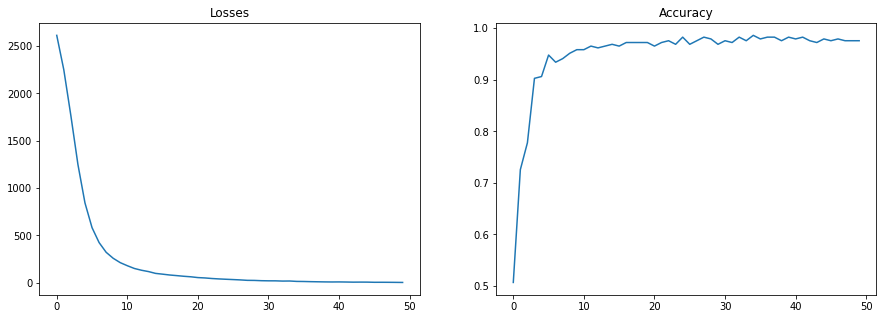

In [72]:
epochs = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(epochs, losses)
ax[0].set_title('Losses')
ax[1].plot(epochs, accuracies)
ax[1].set_title('Accuracy');

# Train set confusion matrix

In [73]:
model.eval()
y_hat = model(Tensor(X_train))
y_pred = np.argmax(y_hat.data, axis=1)

In [74]:
gg_confusion_matrix(y_train, y_pred) + ggsize(500, 500)

In [75]:
cm = confusion_matrix(y_train, y_pred)
score = f1_score_micro(cm)
print(f'F1 score micro: {score}')

F1 score micro: 1.0


# Test set confusion matrix

In [76]:
model.eval()
y_hat = model(Tensor(X_test))
y_pred = np.argmax(y_hat.data, axis=1)

In [77]:
gg_confusion_matrix(y_test, y_pred) + ggsize(500, 500)

In [78]:
cm = confusion_matrix(y_test, y_pred)
score = f1_score_micro(cm)
print(f'F1 score micro: {score}')

F1 score micro: 0.9777777777777777


# Check gradients: introduce corrections, which will allow you to check dropout (hint: in three blocks below)

Для того, чтобы эта функция работала правильно, я добавила random.seed. Тогда выключаются одни и те же вершины при подсчете градиентов разными способами

In [79]:
def gradient_checker(J, grad_J, theta, eps=1e-5, rtol=1e-5):
    """Gradient checker for scalar and vector functions
Args:
    J - function of theta
    grad_J - gradient of function J
    theta - the point for which to compute the numerical gradient
    eps - step value in numerical gradient
    rtol - relative tolerance threshold value
Returns:
    error message if the relative tolerance is greater for some axis
    or "Gradient check passed" else
"""
    it = np.nditer(theta, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:
        ix = it.multi_index
        theta_ = np.array(theta, copy=True)
        theta_[ix] += eps
        J1 = J(theta_)
        theta_ = np.array(theta, copy=True)
        theta_[ix] -= eps
        J2 = J(theta_)

        J1 = to_scalar(J1, ix)
        J2 = to_scalar(J2, ix)

        num_grad = (J1 - J2)/(2*eps)

        rel_tol = np.abs(num_grad - grad_J)[ix]/(1. + np.minimum(np.abs(num_grad), np.abs(grad_J[ix])))

        if rel_tol > rtol:
            print(f'num_grad: {num_grad} grad: {grad_J[ix]} factor: {grad_J[ix] / num_grad}')
            print(f'Incorrect gradient for the axis {str(ix)}')
            return
        it.iternext()
    print(f'Gradient check passed')

In [80]:
def J_theta_global(model, loss_function, theta, idx, x, y):
    np.random.seed(42)
    original = model.parameters[idx].data.copy()
    np.copyto(dst=model.parameters[idx].data, src=theta)
    outputs = model(x)
    loss_value = loss_function(outputs, y).data
    np.copyto(dst=model.parameters[idx].data, src=original)
    model.zero_grad()
    return loss_value

In [81]:
def dJ_theta_global(model, loss_function, x, y):
    np.random.seed(42)
    outputs = model(x)
    loss = loss_function(outputs, y)
    loss.backward()
    grads = []
    for parameter in model.parameters:
        grads.append(parameter.grad.copy())
    model.zero_grad()
    return grads

In [82]:
loss_function = CrossEntropyLoss()
model_ = Feedforward()
np.random.seed(42)
dJ_theta_tensors = dJ_theta_global(model_, loss_function, Tensor(X_val), Tensor(y_val))
global_start = time.time()
for i, parameter in enumerate(model_.parameters):
    start = time.time()
    print(f'[{i}]: Start')
    def J_theta(theta, idx=i, x=Tensor(X_val), y=Tensor(y_val)):
        return J_theta_global(model_, loss_function, theta, idx, x, y)
    gradient_checker(J_theta, dJ_theta_tensors[i], parameter.data)
    print(f'[{i}]: Elapsed time: {time.time() - start:.1f}s')
print(f'Total elapsed time: {time.time() - global_start:.1f}s')

[0]: Start
Gradient check passed
[0]: Elapsed time: 69.2s
[1]: Start
Gradient check passed
[1]: Elapsed time: 0.2s
[2]: Start
Gradient check passed
[2]: Elapsed time: 1.6s
[3]: Start
Gradient check passed
[3]: Elapsed time: 0.1s
Total elapsed time: 71.0s


# 3: Adversarial Attack

# Problem 3 (4.0)

Using `PyTorch` write an implementation of the adversarial attack (any kind you like) for a classifier on MNIST digits.

You can provide a link to your repository if you like, or just write or copy code here.

Сначала напишем и обучим простейшую нейронную сеть, которую мы будем обманывать. По сути это почти то же самое, что было в FeedForward, только теперь с Pytorch

In [70]:
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import copy

from sklearn.metrics import accuracy_score

In [71]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 10)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x: torch.Tensor):
        z1 = self.fc1(x)
        a1 = self.sigmoid(z1)
        z2  = self.fc2(a1)
        return z2

In [72]:
class digits(Dataset):
    def __init__(self, X, y):
        self.X = copy.deepcopy(X)
        self.y = copy.deepcopy(y)
        self.n = self.X.shape[0]

    def __len__(self):
        return self.n

    def __getitem__(self, item):
        return self.X[item], self.y[item]

In [73]:
train_dataset = DataLoader(digits(X_train, y_train), shuffle=True, batch_size=20)
test_dataset = DataLoader(digits(X_test, y_test), shuffle=True, batch_size=20)

In [74]:
num_epochs = 50
model = SimpleNet()
loss_function = F.cross_entropy
optimizer = optim.Adam(model.parameters())

In [75]:
losses = []
accuracies = []

for epoch in range(num_epochs):
    loss_sum = 0
    for data in train_dataset:
        optimizer.zero_grad()
        inputs, targets = data
        outputs = model(inputs.float())
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_sum += loss.data

    output = model(torch.tensor(X_val, dtype=torch.float32))
    y_hat = np.argmax(output.data, axis=1)
    acc = accuracy_score(y_val, y_hat)


    print(f'\r epoch: [{epoch+1}/{num_epochs}], loss: {loss_sum}, acc: {acc} ', end='')
    losses.append(loss_sum)
    accuracies.append(acc)

 epoch: [50/50], loss: 10.05115795135498, acc: 0.9583333333333334 

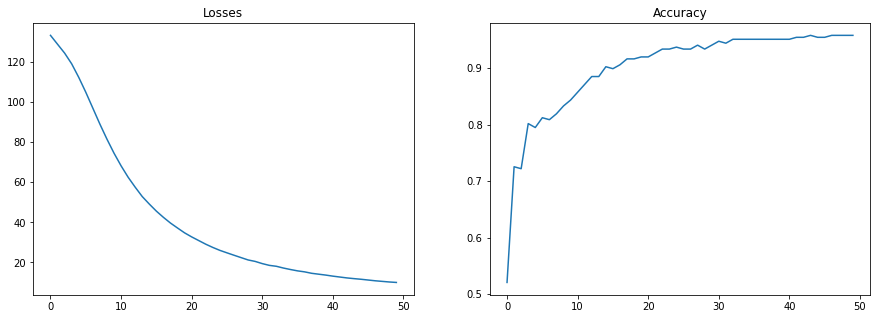

In [76]:
epochs = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(epochs, losses)
ax[0].set_title('Losses')
ax[1].plot(epochs, accuracies)
ax[1].set_title('Accuracy')

Попробуем использовать targeted attack и визуализацию из материалов лекции.

In [92]:
def plot(image, y_pred, score):
    bunch = GGBunch()
    plot = plot_digit(image, caption='Predicted digit: '+str(y_pred))
    bunch.add_plot(plot, 0, 0)
    digit_labels = np.arange(10)
    dat = pd.DataFrame({'labels':digit_labels, 'score':score})
    plot = ggplot(dat) + geom_histogram(aes('labels', 'score'), stat='identity') + scale_x_discrete()
    bunch.add_plot(plot, 500, 0)
    bunch.show()


In [149]:
def predict_digit(X, model=model):
    if torch.is_tensor(X):
        data = X.clone().detach()
    else:
        data = torch.tensor(X, dtype=torch.float32)
    output = nn.Softmax(0)(model(data).detach()).numpy()
    return np.argmax(output), output

In [150]:
x_target = X_test[0]
x_target = torch.tensor(x_target, dtype=torch.float32)
y_pred, score = predict_digit(x_target)
#print(y_pred, score)
plot(X_test[0], y_pred, score)

In [151]:
def grad_update(X, y, model=model):
    data = torch.tensor(X[np.newaxis, :], dtype=torch.float32, requires_grad = True)
    target = torch.tensor(y[np.newaxis, :], dtype=torch.float32)
    loss = F.cross_entropy(model(data), target) + ((x_target-data)**2).sum()
    model.zero_grad()
    loss.backward()
    g = data.grad.data.detach()[0].numpy()
    return g

In [152]:
def targeted_adversarial_example(dig, n=64, n_classes=10, eta=0.01, alpha=0.1, iters=100):
    y = np.zeros(n_classes)
    y[dig] = 1
    x = np.random.normal(loc=0, scale=0.01, size=n)
    for _ in range(iters):
        grad = grad_update(x, y)
        x -= eta*grad
    return x

In [153]:
fake = targeted_adversarial_example(1)
y_pred, score = predict_digit(fake)
plot(fake, y_pred, score)

Получившееся изображение не лучшего качества, но оно явно больше похоже на 5, чем на 1. Подозреваю, что на этом датасете достаточно сложно получить четкую "обманчивую пятерку", потому что разрешение невелико.

# DUE DATE

# The due date is 13 of April 2022 23:59:59

## Instructions

* To submit the assignment, share your workbook with me (with **Can edit** access rights).

* Check, that you found all the tasks in the workbook.  